<left>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Logo_SYGNET.png" width="90" alt="cognitiveclass.ai logo">
</left>

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Tensorflow_logo.svg" width="200" alt="cognitiveclass.ai logo">
</center>




# A.I. Dataset Analysis 
## Part II - Hypothesis Testing and Statistical Analysis

Postprocessing the simulation results from ZSOIL for Neural Network training.

## Objectives

By conducting this thorough data analysis, we'll gain a deeper understanding of the dataset and the underlying physical processes. This will not only help in building a better NN model but also provide valuable insights into the soil subsidence phenomenon in our simulation. These insights can guide feature selection, inform model architecture decisions, and improve interpretability of the NN's results.

*   Data Science with Python
*   Statistics

<h3>Table of Contents</h3>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#II. Hypothesis Testing and Statistical Analysis"><b>II. Hypothesis Testing and Statistical Analysis</b></a></li>
        <li><a href="#- Correlation and Causality">- Correlation and Causality</a></li>
        <li><a href="#- Regression Analysis">- Regression Analysis</a></li>
    </ul>
</div>

<hr>

In [31]:
!pip install statsmodels

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from statsmodels.stats.stattools import omni_normtest, jarque_bera
from scipy.stats import skew, kurtosis

print(scipy.__version__)


1.7.3


First we read the postprocessed file:

In [13]:
combined_data = pd.read_csv('corrected_results.csv')
print(combined_data.head())

           TIME        SF  PUSHOVER LABEL  PUSHOVER LAMBDA  PUSHOVER U-CTRL  \
0           0.0       0.0             0.0              0.0              0.0   
1           0.0       0.0             0.0              0.0              0.0   
2           0.0       0.0             0.0              0.0              0.0   
3           0.0       0.0             0.0              0.0              0.0   
4           0.0       0.0             0.0              0.0              0.0   

   ARC LENGTH STEP  ARC LENGTH U-NORM  ARC LENGTH LOAD FACTOR        NR  \
0              0.0                0.0                     0.0       0.0   
1              0.0                0.0                     0.0       1.0   
2              0.0                0.0                     0.0       2.0   
3              0.0                0.0                     0.0       3.0   
4              0.0                0.0                     0.0       4.0   

          X  ...    Saturation  Fluid velocity-X  Fluid velocity-Y  \
0   

In [15]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.strip()  # Strip leading and trailing spaces
    df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    return df

# Apply the cleaning function to your dataframes
combined_data = clean_column_names(combined_data)

In [9]:
# Identify non-numeric columns
non_numeric_cols = combined_data.select_dtypes(exclude=['float64', 'int64']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index([], dtype='object')


In [10]:
# Apply one-hot encoding to 'Y_category'
combined_data = pd.get_dummies(combined_data, columns=['Y_category'])

print("One-hot encoded Y_category columns:", combined_data.columns)

KeyError: "None of [Index(['Y_category'], dtype='object')] are in the [columns]"

In [11]:
print(combined_data.describe())

               TIME       SF  PUSHOVER LABEL  PUSHOVER LAMBDA  \
count  10241.000000  10241.0         10241.0          10241.0   
mean       1.623474      0.0             0.0              0.0   
std        1.451498      0.0             0.0              0.0   
min        0.000000      0.0             0.0              0.0   
25%        0.000000      0.0             0.0              0.0   
50%        1.000000      0.0             0.0              0.0   
75%        3.000000      0.0             0.0              0.0   
max        4.000000      0.0             0.0              0.0   

       PUSHOVER U-CTRL  ARC LENGTH STEP  ARC LENGTH U-NORM  \
count          10241.0          10241.0            10241.0   
mean               0.0              0.0                0.0   
std                0.0              0.0                0.0   
min                0.0              0.0                0.0   
25%                0.0              0.0                0.0   
50%                0.0              0.0   

### 2. Hypothesis Testing and Statistical Analysis

It can be very helpful in validating assumptions and understanding the relationships between variables.

#### <b>Correlation and Causality</b>:

<b>Pearson/Spearman Correlation:</b> Calculate Pearson or Spearman correlation coefficients to quantify linear and monotonic relationships, respectively.

In [16]:
from scipy.stats import pearsonr, spearmanr

# List of columns to compute correlations with 'Y'
columns_to_correlate = [
    'Displacement-Y', 'Strain-YY', 'Eff.Stress-YY',
    'Tot.Stress-YY', 'Fluid velocity-Y', 'Solid-Velocity-Y',
    'Saturation', 'Pore pressure-'
]

# Initialize a dictionary to store the results
correlation_results = {
    'Variable': [],
    'Pearson Correlation': [],
    'Spearman Correlation': []
}

# Loop over the columns and calculate the correlations
for col in columns_to_correlate:
    # Check if the column or Y is constant
    if np.all(combined_data[col] == combined_data[col].iloc[0]) or np.all(combined_data['Y'] == combined_data['Y'].iloc[0]):
        pearson_corr = np.nan
        spearman_corr = np.nan
    else:
        pearson_corr, _ = pearsonr(combined_data[col], combined_data['Y'])
        spearman_corr, _ = spearmanr(combined_data[col], combined_data['Y'])
    
    # Append the results to the dictionary
    correlation_results['Variable'].append(col.strip())
    correlation_results['Pearson Correlation'].append(pearson_corr)
    correlation_results['Spearman Correlation'].append(spearman_corr)

# Convert the dictionary to a DataFrame
correlation_df = pd.DataFrame(correlation_results)
correlation_df


Variable  Pearson Correlation  Spearman Correlation
0    Displacement-Y            -0.465125             -0.428439
1         Strain-YY             0.600978              0.605669
2     Eff.Stress-YY             0.963419              0.980219
3     Tot.Stress-YY             0.993059              0.992734
4  Fluid velocity-Y            -0.052983              0.117477
5  Solid-Velocity-Y                  NaN                   NaN
6        Saturation            -0.442012             -0.086757
7    Pore pressure-             0.978591              0.978900

<b>ANOVA (Analysis of Variance):</b> If you have categorical variables (e.g., different soil layers), ANOVA can be used to see if the means of a variable (e.g., displacement) are significantly different across categories.

To identify which columns have suitable data for ANOVA, we can iterate through the columns you provided and check each one for variation within the groups. If a column has sufficient variation in all groups (low, medium, and high), we will run the ANOVA test on that column:

In [17]:
from scipy.stats import f_oneway

# Columns to check
columns_to_check = [
    'Displacement-Y', 'Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY',
    'Fluid velocity-Y', 'Solid-Velocity-Y', 'Saturation', 'Pore pressure-'
]

# Function to check variation in a group
def variation(group):
    return np.var(group)

# Create a new categorical variable based on 'Y' ranges, for example, binning 'Y' into 3 categories (low, medium, high)
combined_data['Y_category'] = pd.cut(combined_data['Y'], bins=3, labels=['low', 'medium', 'high'])

# Iterate over columns
for col in columns_to_check:
    print(f"\nChecking column: {col}")
    
    # Group data based on Y_category
    group_low = combined_data[combined_data['Y_category'] == 'low'][col]
    group_medium = combined_data[combined_data['Y_category'] == 'medium'][col]
    group_high = combined_data[combined_data['Y_category'] == 'high'][col]
    
    # Calculate variation in each group
    var_low = variation(group_low)
    var_medium = variation(group_medium)
    var_high = variation(group_high)
    
    print(f"Variation in Low group: {var_low}")
    print(f"Variation in Medium group: {var_medium}")
    print(f"Variation in High group: {var_high}")
    
    # Check if there is variation in all groups
    if not (np.isnan(var_low) or np.isnan(var_medium) or np.isnan(var_high)):
        if var_low > 0 and var_medium > 0 and var_high > 0:
            # Perform ANOVA
            f_statistic, p_value = f_oneway(group_low, group_medium, group_high)
            print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")
        else:
            print("Insufficient variation in one or more groups. ANOVA not performed.")
    else:
        print("One or more groups contain only NaN values or have zero variation. ANOVA not performed.")


Checking column: Displacement-Y
Variation in Low group: 0.2430919594550806
Variation in Medium group: 0.9297712567719657
Variation in High group: 1.0090569730141894
ANOVA F-statistic: 2607.1511923661474, p-value: 0.0

Checking column: Strain-YY
Variation in Low group: 3.52976554009092e-10
Variation in Medium group: 3.1976612308020637e-10
Variation in High group: 4.9626079018502957e-11
ANOVA F-statistic: 4162.691451855131, p-value: 0.0

Checking column: Eff.Stress-YY
Variation in Low group: 1185.574018601214
Variation in Medium group: 3002.1608027811803
Variation in High group: 5936.22877703376
ANOVA F-statistic: 48910.24912946666, p-value: 0.0

Checking column: Tot.Stress-YY
Variation in Low group: 5481.9965490608865
Variation in Medium group: 5817.9856407846655
Variation in High group: 5943.699965820475
ANOVA F-statistic: 57251.606056739554, p-value: 0.0

Checking column: Fluid velocity-Y
Variation in Low group: 1.3776355298736226e-05
Variation in Medium group: 0.005540858956869683
V

Creating a Categorical Variable Based on 'Y' Values and running tests on key variables.

In [18]:
# List of columns to check for ANOVA
columns_to_check = ['Displacement-Y','Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY', 
                    'Fluid velocity-Y', 'Saturation', 'Pore pressure-']

# Dictionary to store ANOVA results
anova_results = {}

# Loop through each column and perform ANOVA if variation is present
for column in columns_to_check:
    # Extract data for each Y category
    group_low = combined_data[combined_data['Y_category'] == 'low'][column]
    group_medium = combined_data[combined_data['Y_category'] == 'medium'][column]
    group_high = combined_data[combined_data['Y_category'] == 'high'][column]

    # Check standard deviation (variation) in each group
    std_low = np.std(group_low)
    std_medium = np.std(group_medium)
    std_high = np.std(group_high)

    print(f"\nChecking column: {column}")
    print(f"Standard Deviation in Low group: {std_low}")
    print(f"Standard Deviation in Medium group: {std_medium}")
    print(f"Standard Deviation in High group: {std_high}")

    # Proceed with ANOVA only if there is non-zero standard deviation in all groups
    if all(std > 0 for std in [std_low, std_medium, std_high]):
        f_statistic, p_value = f_oneway(group_low, group_medium, group_high)
        anova_results[column] = {
            'F-statistic': f_statistic,
            'p-value': p_value,
            'std_low': std_low,
            'std_medium': std_medium,
            'std_high': std_high
        }
        print(f"ANOVA F-statistic: {f_statistic}, p-value: {p_value}")
    else:
        print(f"Insufficient variation in one or more groups for column: {column}. ANOVA not performed.")
        anova_results[column] = {
            'F-statistic': None,
            'p-value': None,
            'std_low': std_low,
            'std_medium': std_medium,
            'std_high': std_high
        }

# Convert ANOVA results into a DataFrame for better visualization and analysis
anova_results_df = pd.DataFrame.from_dict(anova_results, orient='index')
print("\nANOVA Results Summary:")
anova_results_df



Checking column: Displacement-Y
Standard Deviation in Low group: 0.49304356750198114
Standard Deviation in Medium group: 0.9642464709668196
Standard Deviation in High group: 1.0045182790841536
ANOVA F-statistic: 2607.1511923661474, p-value: 0.0

Checking column: Strain-YY
Standard Deviation in Low group: 1.8787670265604834e-05
Standard Deviation in Medium group: 1.7882005566496346e-05
Standard Deviation in High group: 7.044577987253953e-06
ANOVA F-statistic: 4162.691451855131, p-value: 0.0

Checking column: Eff.Stress-YY
Standard Deviation in Low group: 34.432165464884925
Standard Deviation in Medium group: 54.791977540340525
Standard Deviation in High group: 77.04692581170102
ANOVA F-statistic: 48910.24912946666, p-value: 0.0

Checking column: Tot.Stress-YY
Standard Deviation in Low group: 74.04050613725494
Standard Deviation in Medium group: 76.27572117512011
Standard Deviation in High group: 77.09539523097651
ANOVA F-statistic: 57251.606056739554, p-value: 0.0

Checking column: Flu

F-statistic       p-value    std_low  std_medium   std_high
Displacement-Y     2607.151192  0.000000e+00   0.493044    0.964246   1.004518
Strain-YY          4162.691452  0.000000e+00   0.000019    0.000018   0.000007
Eff.Stress-YY     48910.249129  0.000000e+00  34.432165   54.791978  77.046926
Tot.Stress-YY     57251.606057  0.000000e+00  74.040506   76.275721  77.095395
Fluid velocity-Y     35.734790  3.274925e-16   0.003712    0.074437   0.168789
Saturation         1857.557217  0.000000e+00   0.500132    0.445844   0.137169
Pore pressure-    45435.471995  0.000000e+00  41.547650   35.593604  53.357517

The violin plot and bar plot.

Violin plots combine the features of boxplots and density plots. They show the distribution of the data across different groups and provide a clear visual of the data’s density.

Bar charts with Error Bars can be used to display the mean values of different groups, and error bars can be added to show the variability (e.g., standard error or confidence intervals). This helps in visualizing the differences between group means

/tmp/ipykernel_1730/1982052729.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = combined_data.groupby('Y_category')[column].mean()
/tmp/ipykernel_1730/1982052729.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stds = combined_data.groupby('Y_category')[column].std()


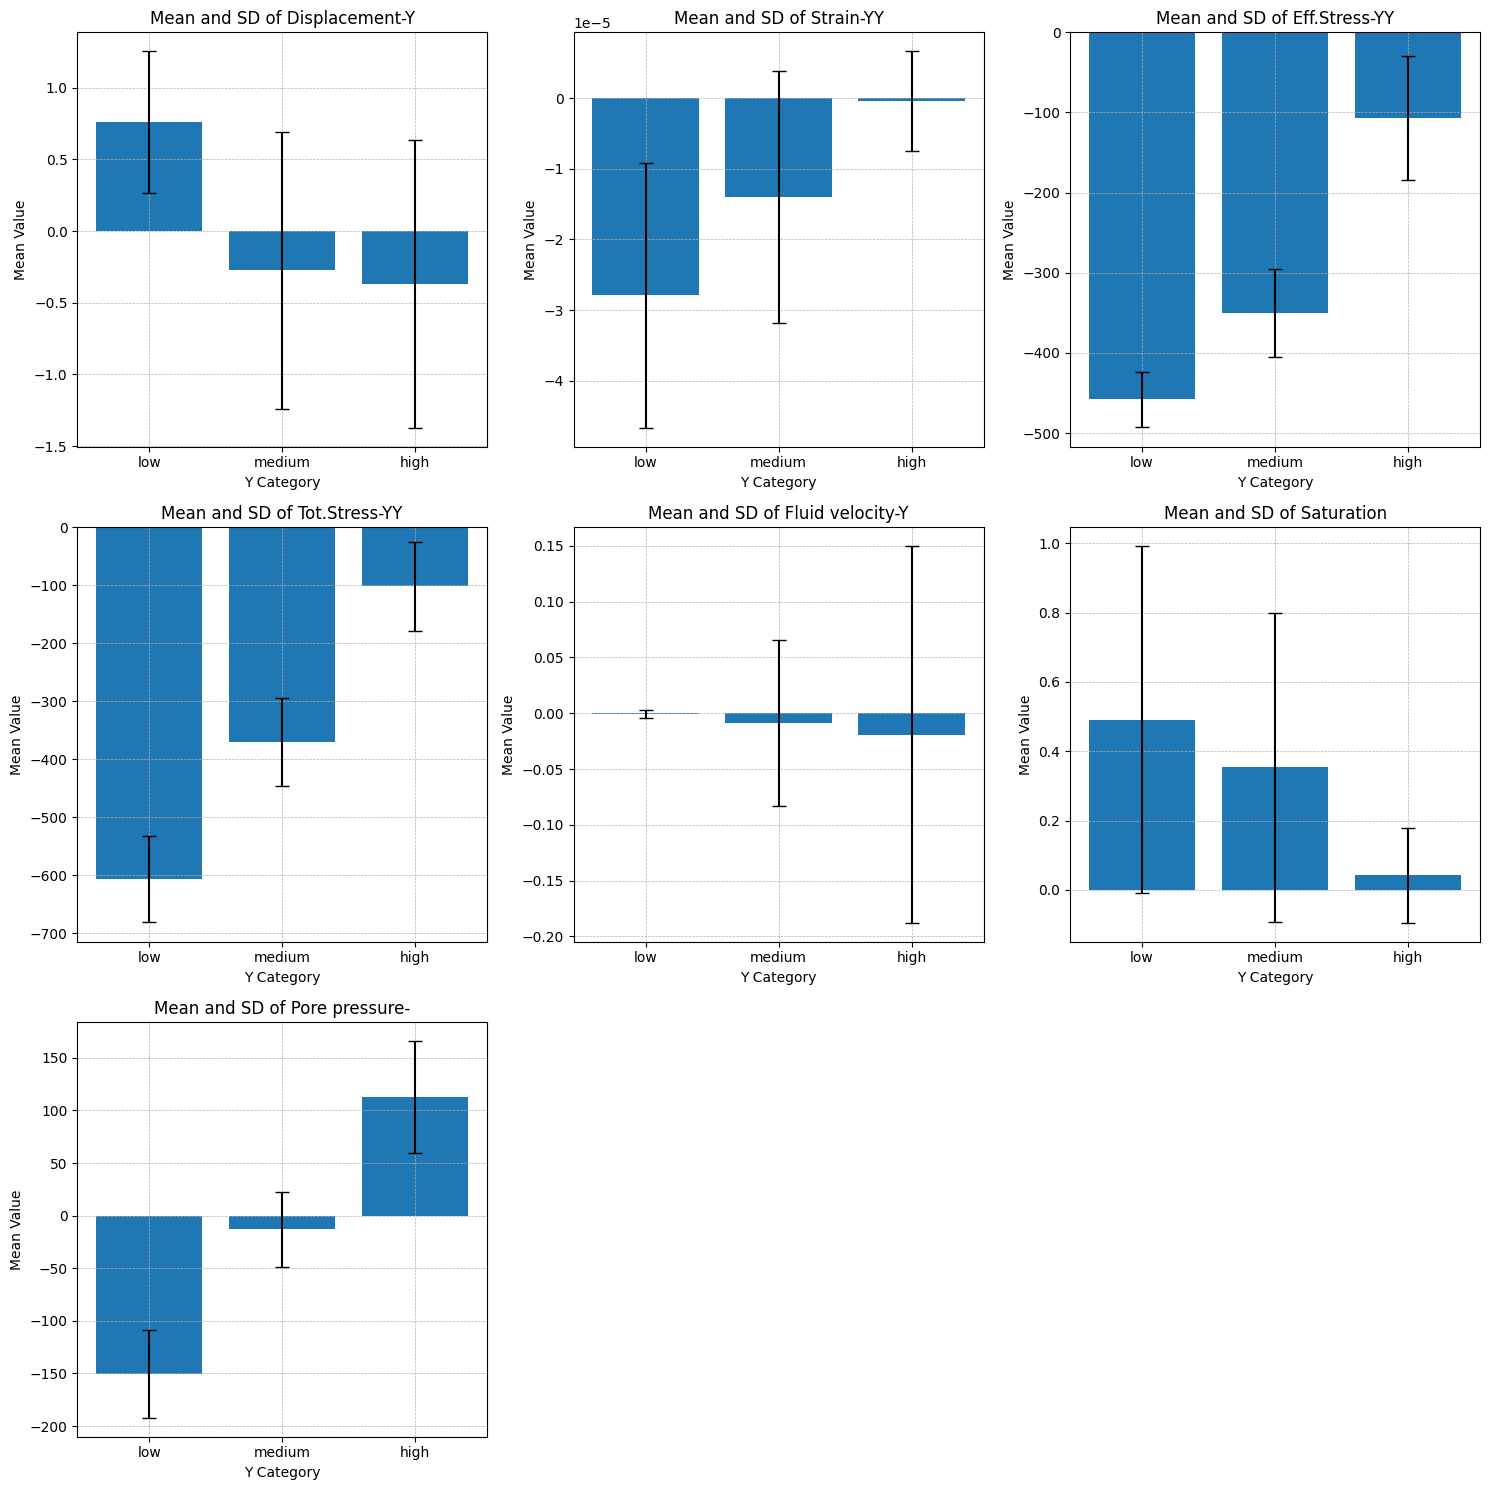

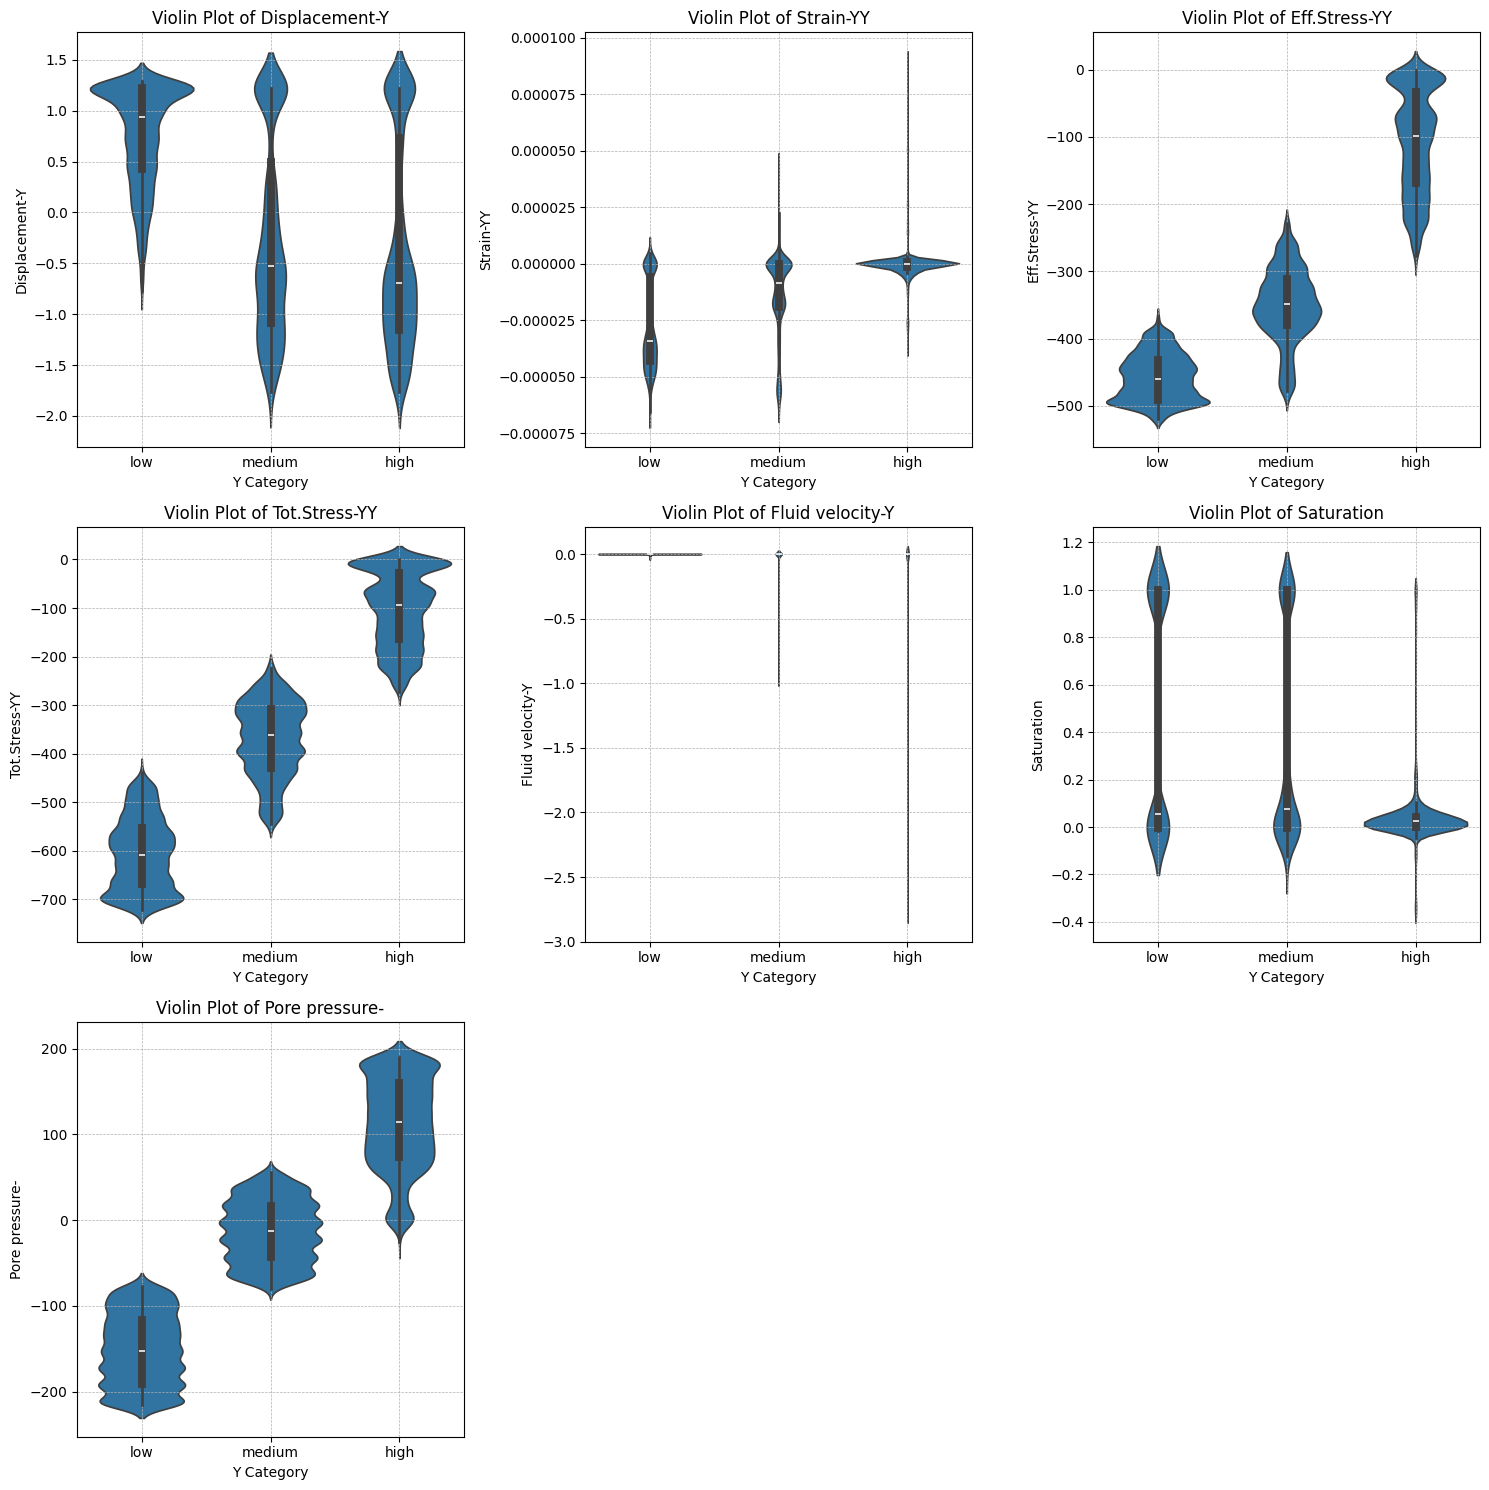

In [9]:
# Number of columns to display per row in the grouped plot
cols = 3

# Determine the number of rows needed
num_rows = int(np.ceil(len(anova_results_df) / cols))

# Create a figure for the bar plots
plt.figure(figsize=(cols * 5, num_rows * 5))
for i, column in enumerate(anova_results_df.index, 1):
    plt.subplot(num_rows, cols, i)
    means = combined_data.groupby('Y_category')[column].mean()
    stds = combined_data.groupby('Y_category')[column].std()
    plt.bar(means.index, means.values, yerr=stds.values, capsize=5)
    plt.title(f'Mean and SD of {column}')
    plt.xlabel('Y Category')
    plt.ylabel('Mean Value')
    plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Violin Plots of ANOVA.png')
plt.show()

# Create a figure for the violin plots
plt.figure(figsize=(cols * 5, num_rows * 5))
for i, column in enumerate(anova_results_df.index, 1):
    plt.subplot(num_rows, cols, i)
    sns.violinplot(x='Y_category', y=column, data=combined_data)
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Y Category')
    plt.ylabel(column)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Box Plots with Error Bars for ANOVa.png')
plt.show()


Interaction Plots:

If you are dealing with a two-way ANOVA, interaction plots can be very informative. They show how the levels of one factor affect the response variable at different levels of another factor.

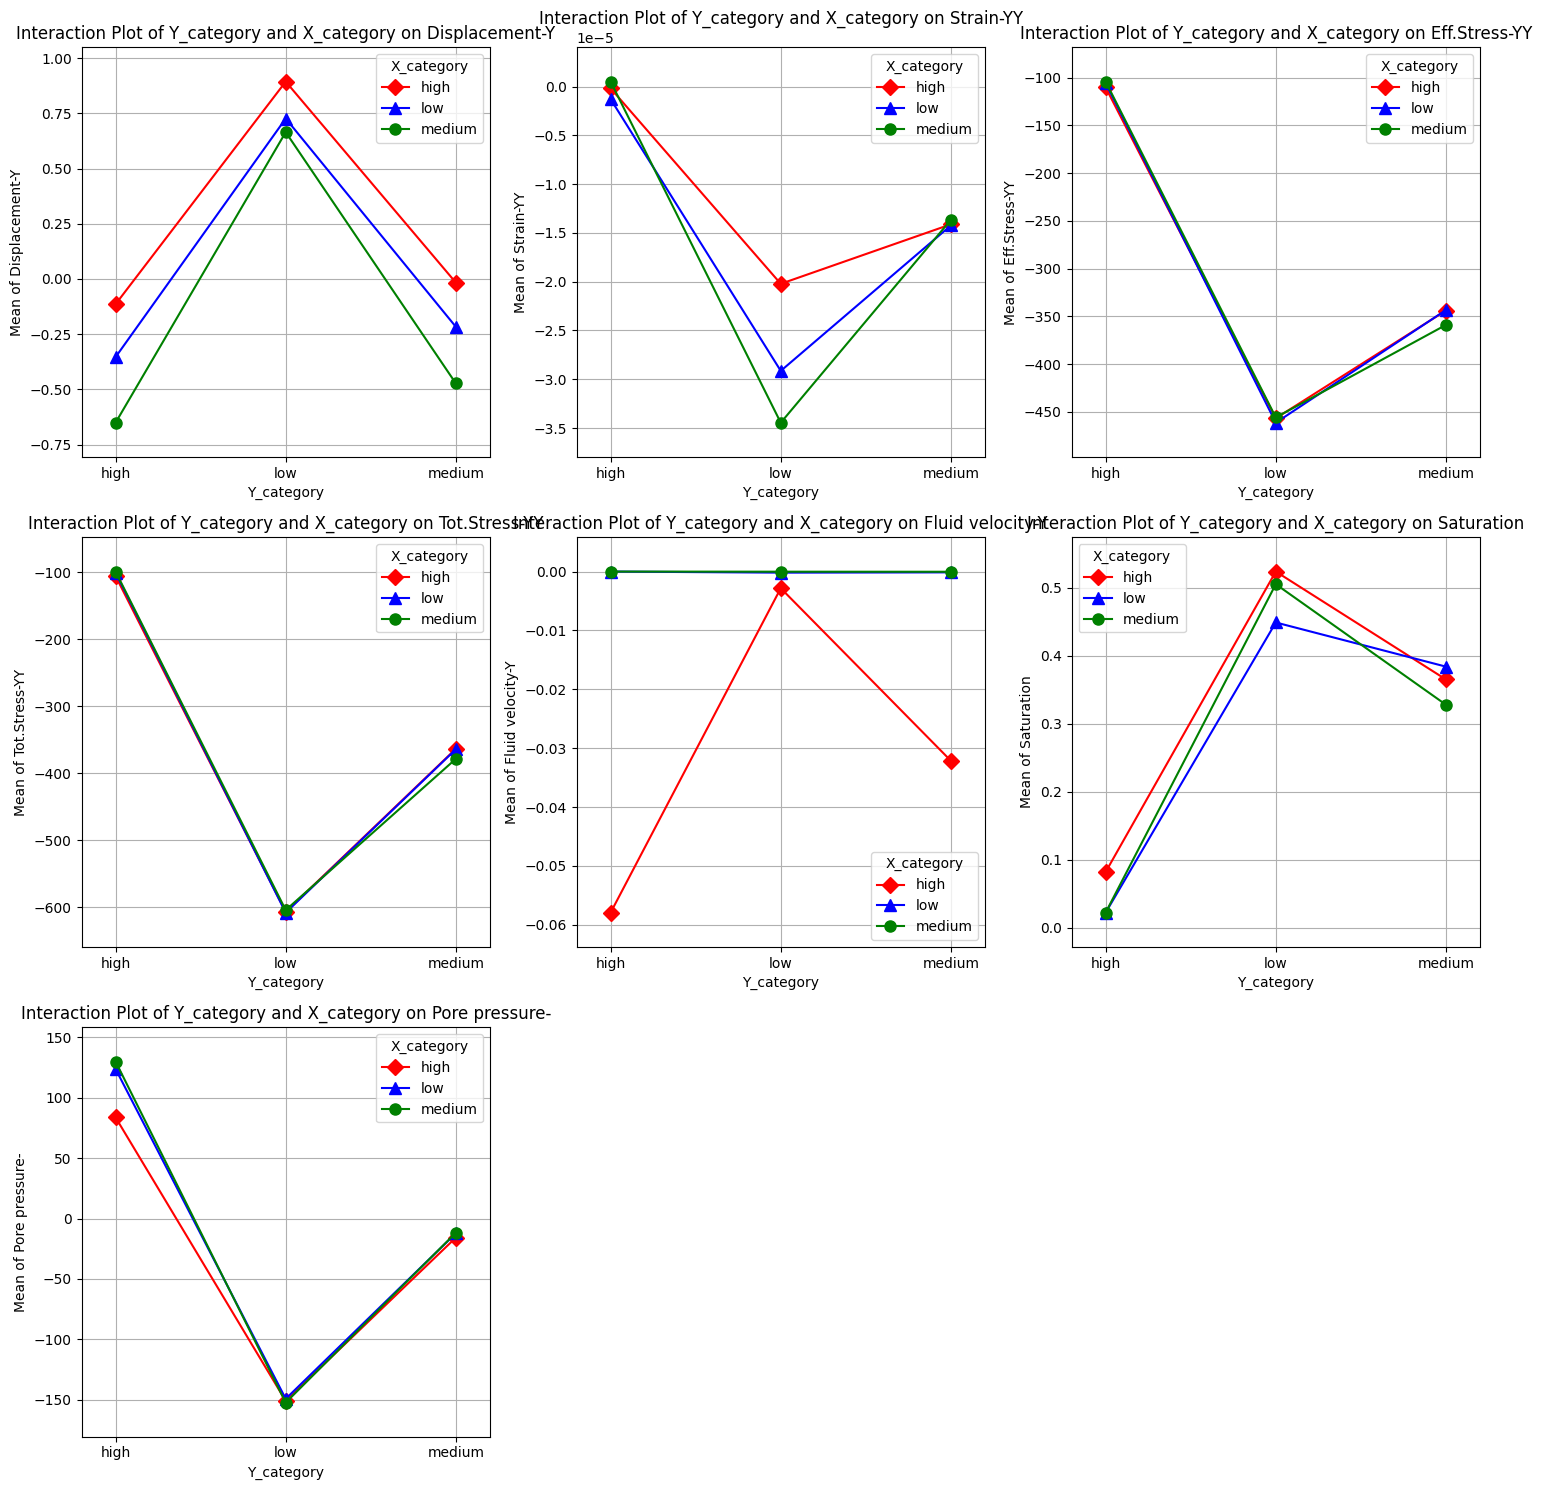

In [29]:
from statsmodels.graphics.factorplots import interaction_plot

combined_data['X_category'] = pd.cut(combined_data['X'], bins=3, labels=['low', 'medium', 'high'])

# Ensure both are categorical and convert to string
combined_data['Y_category'] = combined_data['Y_category'].astype('category').astype(str)
combined_data['X_category'] = combined_data['X_category'].astype('category').astype(str)

# List of columns to generate interaction plots for
anova_columns = ['Displacement-Y', 'Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY', 
                 'Fluid velocity-Y', 'Saturation', 'Pore pressure-']

# Determine the number of rows and columns for subplots
num_rows = (len(anova_columns) + 2) // 3  # Adjust the number of rows based on the number of columns

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and create interaction plots
for i, column in enumerate(anova_columns):
    interaction_plot(combined_data['Y_category'], combined_data['X_category'], combined_data[column], 
                     colors=['red', 'blue', 'green'], markers=['D', '^', 'o'], ms=8, ax=axes[i])
    axes[i].set_title(f'Interaction Plot of Y_category and X_category on {column}')
    axes[i].set_xlabel('Y_category')
    axes[i].set_ylabel(f'Mean of {column}')
    axes[i].grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('Interaction Plots of ANOVA.png')
plt.show()


Scatter Plots with Grouping:

Scatter plots can be used to visualize the relationship between two variables, with different colors or shapes representing different groups. This can help in identifying patterns or trends within the data.

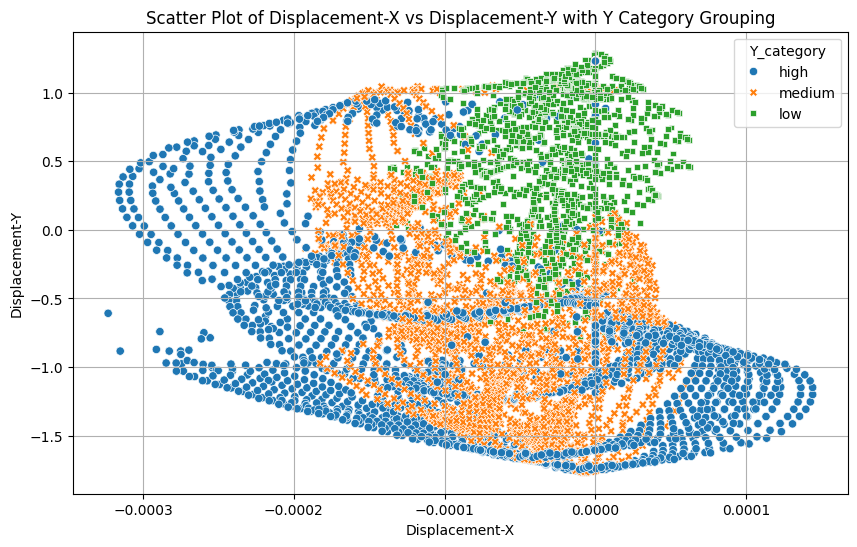

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Displacement-X', y='Displacement-Y', hue='Y_category', style='Y_category', data=combined_data)
plt.title('Scatter Plot of Displacement-X vs Displacement-Y with Y Category Grouping')
plt.xlabel('Displacement-X')
plt.ylabel('Displacement-Y')
plt.grid(True)
plt.savefig('Scatter Plot of Displacement-X vs Displacement-Y with Y Category Grouping ANOVA.png')
plt.show()

QQ Plots:

QQ plots (Quantile-Quantile plots) are useful for checking the normality assumption of the residuals in ANOVA. They compare the distribution of the residuals to a normal distribution.

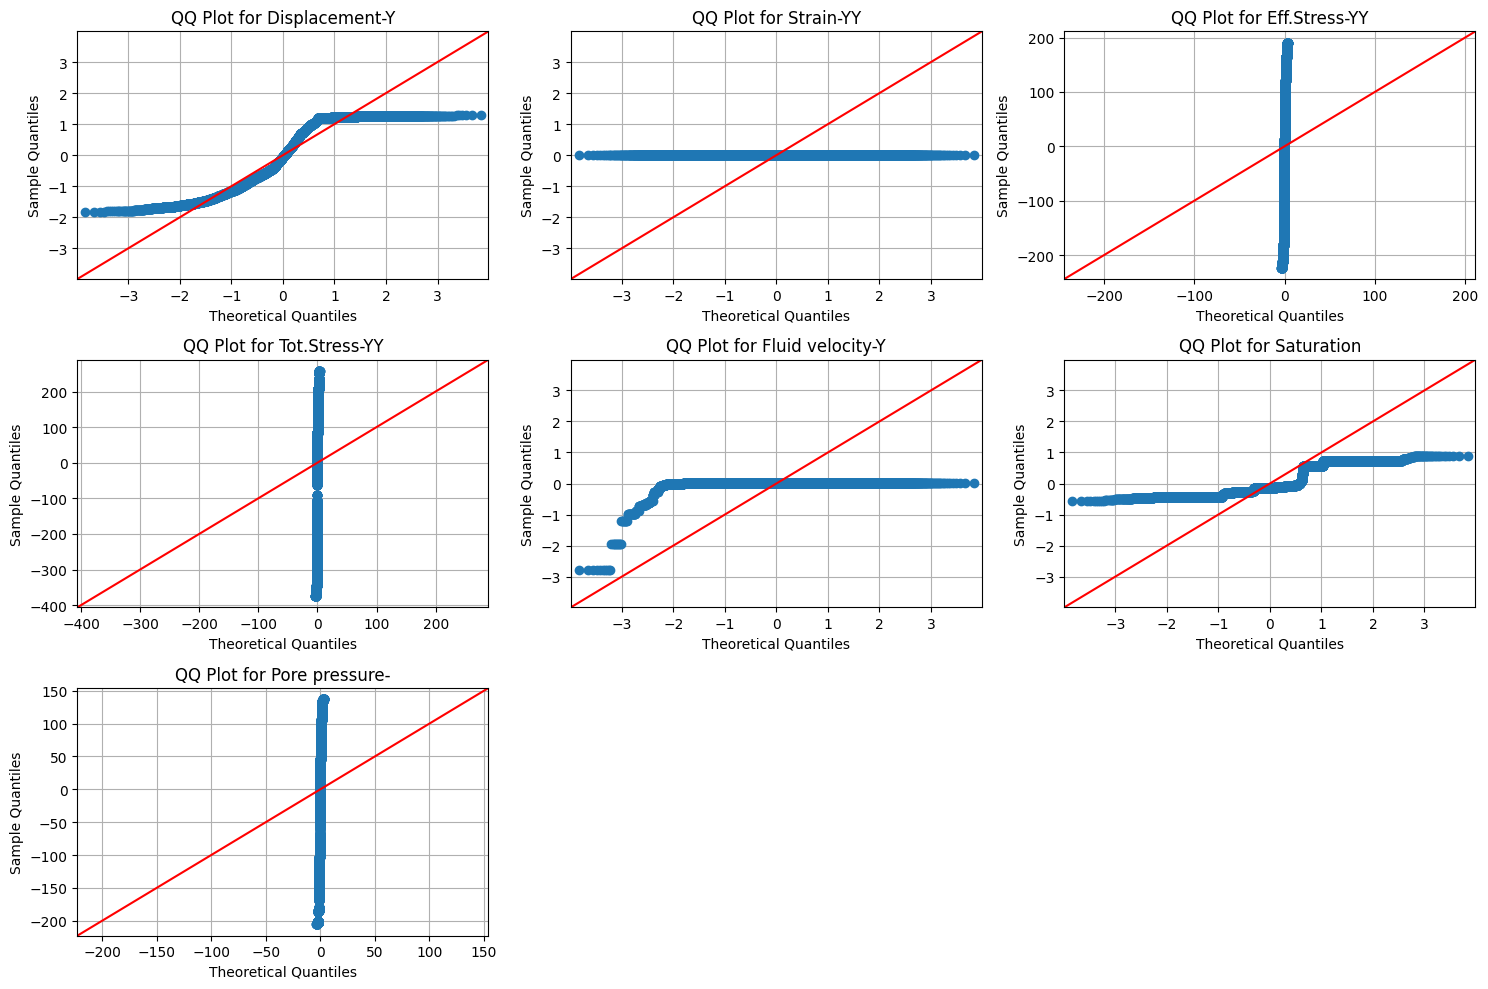

In [13]:
plt.figure(figsize=(15, 10))
num_plots = len(anova_results_df.index)
for i, column in enumerate(anova_results_df.index):
    plt.subplot((num_plots // 3) + 1, 3, i + 1)  # Adjust grid size
    model = sm.OLS(combined_data[column], sm.add_constant(combined_data['Y_category'].astype('category').cat.codes))
    results = model.fit()
    residuals = results.resid

    sm.qqplot(residuals, line='45', ax=plt.gca())
    plt.title(f'QQ Plot for {column}')
    plt.grid(True)

plt.tight_layout()
plt.savefig('Quantile-Quantile Plots of ANOVA.png')
plt.show()

Heatmap:

By using color gradients, heatmaps can quickly show where significant differences lie between groups simplifying the interpretation of complex statistical results. This can help in identifying which groups differ significantly from each other after performing ANOVA.

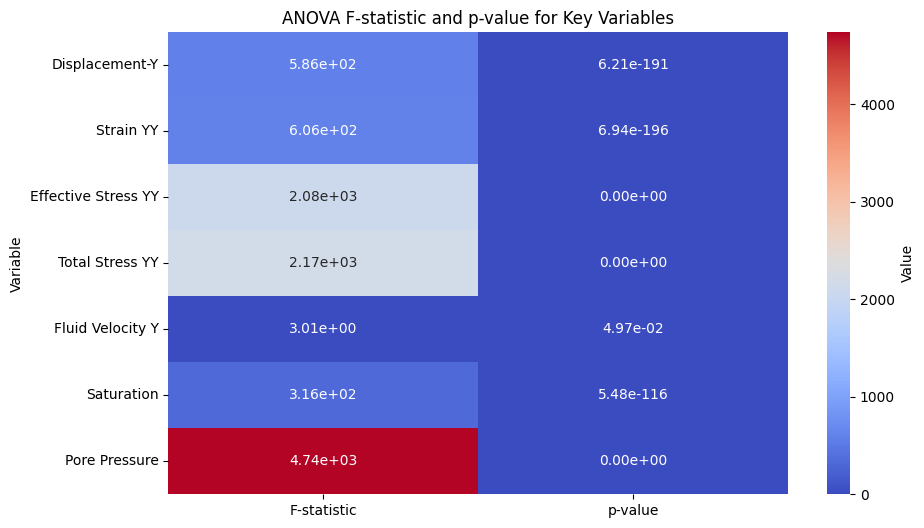

In [14]:
# Data
data = {
    'Variable': ['Displacement-Y', 'Strain YY', 'Effective Stress YY', 'Total Stress YY', 'Fluid Velocity Y', 'Saturation', 'Pore Pressure'],
    'F-statistic': [586.308666, 606.365522, 2084.943300, 2167.430015, 3.006859, 315.740613, 4738.780310],
    'p-value': [6.212328e-191, 6.944975e-196, 0.000000e+00, 0.000000e+00, 4.973143e-02, 5.480854e-116, 0.000000e+00]
}

df = pd.DataFrame(data)
df.set_index('Variable', inplace=True)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, fmt=".2e", cmap='coolwarm', cbar_kws={'label': 'Value'})
plt.title('ANOVA F-statistic and p-value for Key Variables')
plt.savefig('ANOVA F-statistic and p-value for Key Variables.png')
plt.show()

#### <b>Regression Analysis</b>:

<b>Linear Regression:</b> Explore relationships between variables using simple or multiple linear regression. This can help in identifying the key predictors of soil subsidence.

In [34]:
# Define your variables
variables = ['Displacement-Y', 'Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY', 
             'Fluid velocity-Y', 'Saturation', 'Pore pressure-']

# Generate all possible combinations of the variables
combinations = list(itertools.combinations(variables, 2))

# List to store OLS results
results_list = []

# Loop through each combination and perform linear regression
for combo in combinations:
    X = combined_data[list(combo)]
    y = combined_data['Displacement-Y']  # Assuming 'Displacement-Y' is always the dependent variable
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    results_list.append((combo, model))

# Function to extract key information from each OLS result
def extract_ols_summary(combo, ols_result):
    # Perform Omnibus normality test
    omni_test = sm.stats.omni_normtest(ols_result.resid)
    jarque_bera_test = sm.stats.jarque_bera(ols_result.resid)
    
    summary_data = {
        "Combination": f"{combo}",
        "Dependent Variable": ols_result.model.endog_names,
        "R-squared": ols_result.rsquared,
        "Adj. R-squared": ols_result.rsquared_adj,
        "F-statistic": ols_result.fvalue,
        "Prob (F-statistic)": ols_result.f_pvalue,
        "Log-Likelihood": ols_result.llf,
        "AIC": ols_result.aic,
        "BIC": ols_result.bic,
        "Number of Observations": ols_result.nobs,
        "Df Residuals": ols_result.df_resid,
        "Df Model": ols_result.df_model,
        "Covariance Type": ols_result.cov_type,
        "Durbin-Watson": sm.stats.durbin_watson(ols_result.resid),
        "Omnibus": omni_test.statistic,
        "Prob (Omnibus)": omni_test.pvalue,
        "Jarque-Bera (JB)": jarque_bera_test[0],
        "Prob(JB)": jarque_bera_test[1],
        "Skew": ols_result.resid.skew(),
        "Kurtosis": ols_result.resid.kurtosis(),
        "Condition Number": ols_result.condition_number,
    }
    
    # Extract coefficients
    coeffs = ols_result.params
    std_errs = ols_result.bse
    t_values = ols_result.tvalues
    p_values = ols_result.pvalues
    conf_int = ols_result.conf_int()
    
    for var in coeffs.index:
        summary_data[f'{var}_coef'] = coeffs[var]
        summary_data[f'{var}_std_err'] = std_errs[var]
        summary_data[f'{var}_t_value'] = t_values[var]
        summary_data[f'{var}_p_value'] = p_values[var]
        summary_data[f'{var}_conf_lower'] = conf_int.loc[var, 0]
        summary_data[f'{var}_conf_upper'] = conf_int.loc[var, 1]
    
    return summary_data

# Create a summary table for all OLS results
summary_table = pd.DataFrame([extract_ols_summary(combo, result) for combo, result in results_list])

# Display the summary table
print(summary_table)

# Optionally, save the table to a CSV file
summary_table.to_csv('ols_summary_table.csv', index=False)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                               Combination Dependent Variable  R-squared  \
0          ('Displacement-Y', 'Strain-YY')     Displacement-Y   1.000000   
1      ('Displacement-Y', 'Eff.Stress-YY')     Displacement-Y   1.000000   
2      ('Displacement-Y', 'Tot.Stress-YY')     Displacement-Y   1.000000   
3   ('Displacement-Y', 'Fluid velocity-Y')     Displacement-Y   1.000000   
4         ('Displacement-Y', 'Saturation')     Displacement-Y   1.000000   
5     ('Displacement-Y', 'Pore pressure-')     Displacement-Y   1.000000   
6           ('Strain-YY', 'Eff.Stress-YY')     Displacement-Y   0.155321   
7           ('Strain-YY', 'Tot.Stress-YY')     Displacement-Y   0.207723   
8        ('Strain-YY', 'Fluid velocity-Y')     Displacement-Y   0.073301   
9              ('Strain-YY', 'Saturation')     Displacement-Y   0.086800   
10         ('Strain-YY', 'Pore pressure-')     Displacement-Y   0.246730   
11      ('Eff.Stress-YY', 'Tot.Stress-YY')     Displacement-Y   0.281674   
12   ('Eff.S

Plot Residuals: Create residual plots to check for patterns that might indicate non-linearity, heteroscedasticity, or outliers.

                           Combination  R-squared  Adj. R-squared  \
0          (Displacement-Y, Strain-YY)   1.000000        1.000000   
1      (Displacement-Y, Eff.Stress-YY)   1.000000        1.000000   
2      (Displacement-Y, Tot.Stress-YY)   1.000000        1.000000   
3   (Displacement-Y, Fluid velocity-Y)   1.000000        1.000000   
4         (Displacement-Y, Saturation)   1.000000        1.000000   
5     (Displacement-Y, Pore pressure-)   1.000000        1.000000   
6           (Strain-YY, Eff.Stress-YY)   0.155321        0.155216   
7           (Strain-YY, Tot.Stress-YY)   0.207723        0.207624   
8        (Strain-YY, Fluid velocity-Y)   0.073301        0.073185   
9              (Strain-YY, Saturation)   0.086800        0.086686   
10         (Strain-YY, Pore pressure-)   0.246730        0.246636   
11      (Eff.Stress-YY, Tot.Stress-YY)   0.281674        0.281584   
12   (Eff.Stress-YY, Fluid velocity-Y)   0.152389        0.152283   
13         (Eff.Stress-YY, Saturat

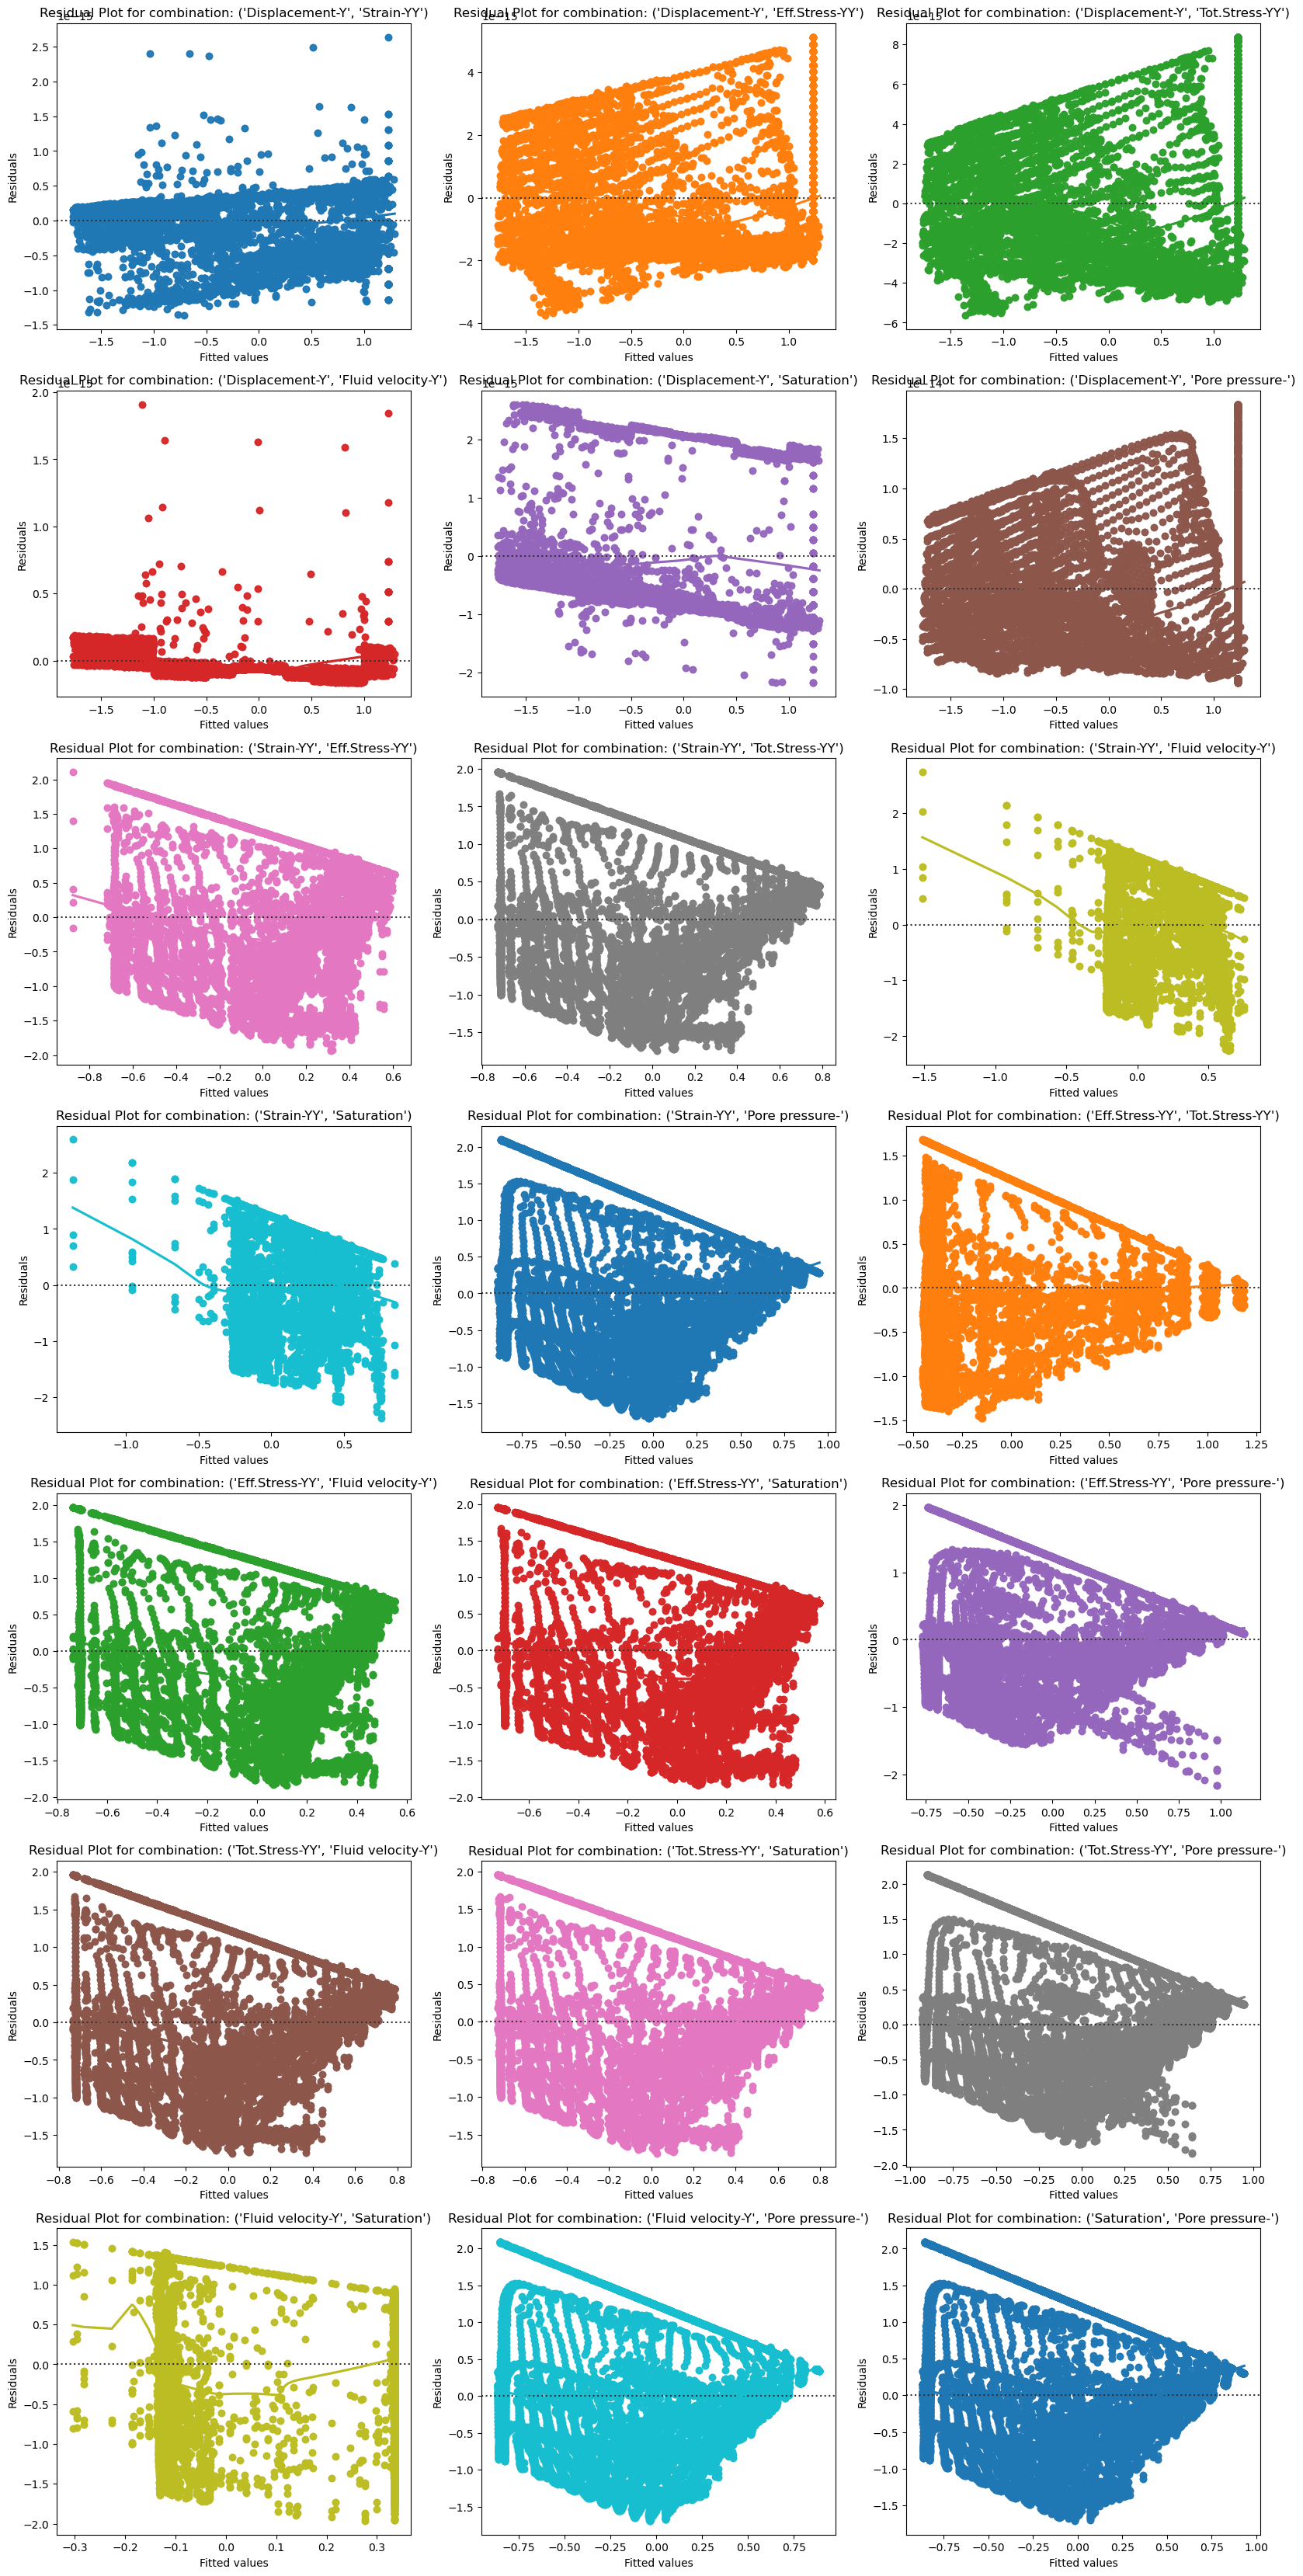

In [36]:
import itertools

# Define your variables
variables = ['Displacement-Y', 'Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY', 'Fluid velocity-Y', 'Saturation', 'Pore pressure-']

# Generate all possible combinations of the variables
combinations = list(itertools.combinations(variables, 2))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=(len(combinations) + 2) // 3, ncols=3, figsize=(20, len(combinations) * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize a list to store the summary data
summary_data = []

# Loop through each combination and perform linear regression
for i, combo in enumerate(combinations):
    X = combined_data[list(combo)]
    y = combined_data['Displacement-Y']  # Assuming 'Displacement-Y' is always the dependent variable
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    
    # Plot residuals on the corresponding subplot
    sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, ax=axes[i])
    axes[i].set_xlabel('Fitted values')
    axes[i].set_ylabel('Residuals')
    axes[i].set_title(f'Residual Plot for combination: {combo}')
    
    
# Store the summary data
    summary_data.append({
        'Combination': combo,
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'F-statistic': model.fvalue,
        'Prob (F-statistic)': model.f_pvalue,
        'AIC': model.aic,
        'BIC': model.bic
    })

# Convert the summary data to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary DataFrame
print(summary_df)

# Adjust layout
plt.tight_layout()
plt.savefig('Residual Plot for Linear Regression combinations.png')
plt.show()

Normality Test: Perform a normality test (e.g., Shapiro-Wilk test) on the residuals to ensure they are normally distributed.

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


                           Combination  Shapiro-Wilk Statistic  \
0          (Displacement-Y, Strain-YY)                0.893490   
1      (Displacement-Y, Eff.Stress-YY)                0.919124   
2      (Displacement-Y, Tot.Stress-YY)                0.933519   
3   (Displacement-Y, Fluid velocity-Y)                0.891064   
4         (Displacement-Y, Saturation)                0.903907   
5     (Displacement-Y, Pore pressure-)                0.948945   
6           (Strain-YY, Eff.Stress-YY)                0.978116   
7           (Strain-YY, Tot.Stress-YY)                0.977406   
8        (Strain-YY, Fluid velocity-Y)                0.937946   
9              (Strain-YY, Saturation)                0.944956   
10         (Strain-YY, Pore pressure-)                0.975097   
11      (Eff.Stress-YY, Tot.Stress-YY)                0.925068   
12   (Eff.Stress-YY, Fluid velocity-Y)                0.979433   
13         (Eff.Stress-YY, Saturation)                0.979393   
14     (Ef

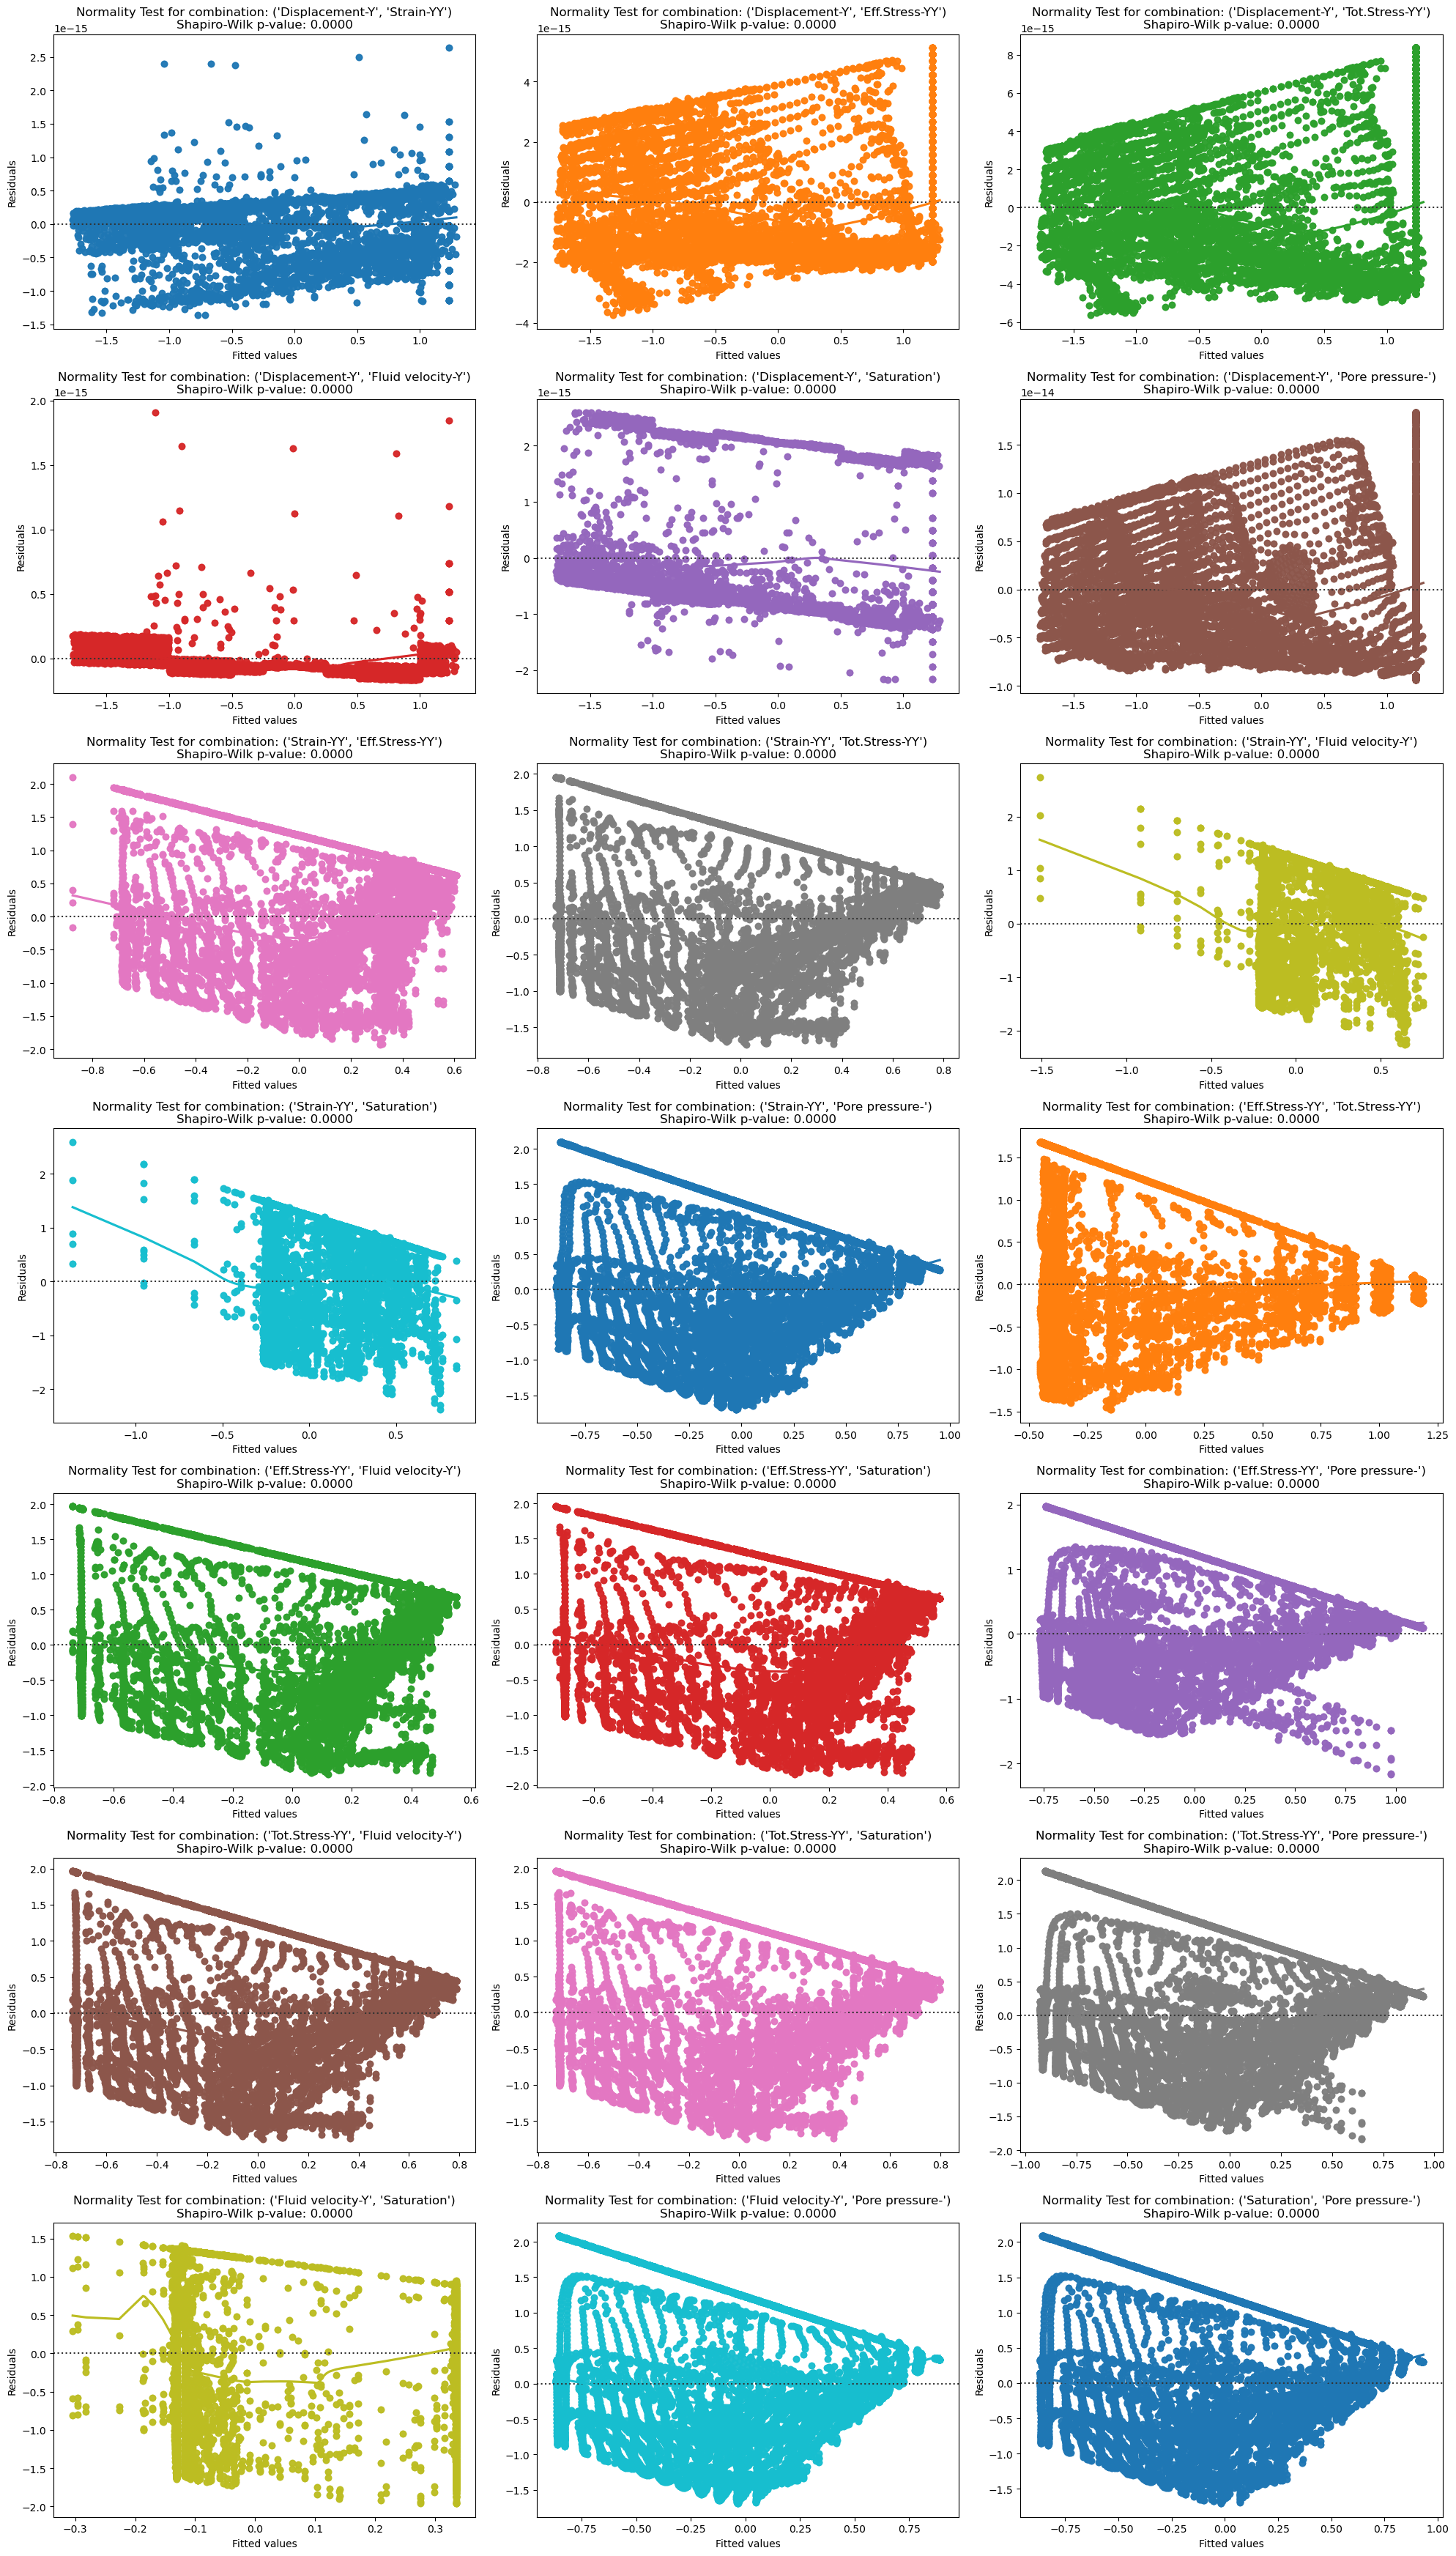

In [37]:
# Define your variables
variables = ['Displacement-Y', 'Strain-YY', 'Eff.Stress-YY', 'Tot.Stress-YY', 'Fluid velocity-Y', 'Saturation', 'Pore pressure-']

# Generate all possible combinations of the variables
combinations = list(itertools.combinations(variables, 2))

# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 35))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize a list to store the summary data
summary_data = []

# Loop through each combination and perform linear regression
for i, combo in enumerate(combinations):
    X = combined_data[list(combo)]
    y = combined_data['Displacement-Y']  # Assuming 'Displacement-Y' is always the dependent variable
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    residuals = model.resid
    
    # Perform Shapiro-Wilk test
    shapiro_test = stats.shapiro(residuals)
    
    
    # Plot residuals on the corresponding subplot
    sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, ax=axes[i])
    axes[i].set_xlabel('Fitted values')
    axes[i].set_ylabel('Residuals')
    axes[i].set_title(f'Normality Test for combination: {combo}\nShapiro-Wilk p-value: {shapiro_test.pvalue:.4f}')
    
# Store the summary data
    summary_data.append({
        'Combination': combo,
        'Shapiro-Wilk Statistic': shapiro_test.statistic,
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'F-statistic': model.fvalue,
        'Prob (F-statistic)': model.f_pvalue,
        'AIC': model.aic,
        'BIC': model.bic
    })

# Convert the summary data to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary DataFrame
print(summary_df)

# Adjust layout
plt.tight_layout()
plt.savefig('Normality Tests for Residuals - Shapiro-Wilk p-value.png')
plt.show()


<b>Principal Component Analysis (PCA):</b> PCA can be used to reduce dimensionality and understand which combinations of variables explain most of the variance in the data.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
# Adjust columns as necessary
principal_components = pca.fit_transform(combined_data.drop(columns=['X', 'Y', 'TIME']))
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component: {explained_variance}")
explained_variance_df = pd.DataFrame(explained_variance)
explained_variance_df

Explained variance by component: [0.62823281 0.25411073 0.05832555]


0
0  0.628233
1  0.254111
2  0.058326

<i>Scree Plot</i> shows the explained variance by each principal component. This helps you determine how many components are necessary to capture the majority of the variance

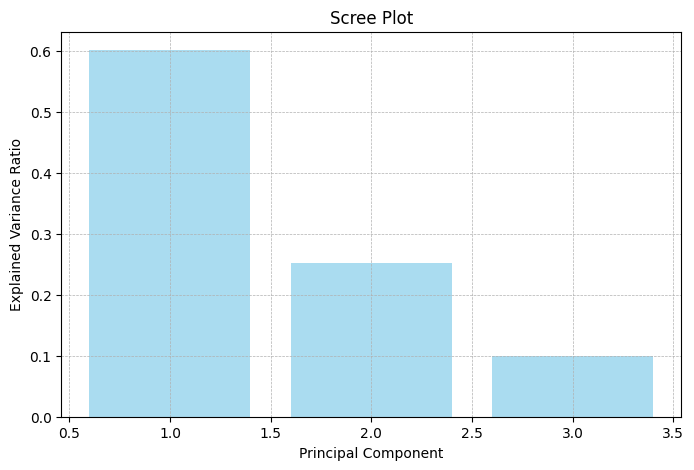

In [70]:
# Create a scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', color='skyblue')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.savefig('Scree Plot of Principal Component Analysis.png')
plt.show()

<i>2D/3D Scatter Plots</i>: Plot the data points on a 2D or 3D scatter plot using the principal components as axes. This is useful to visualize the separation or clustering of the data in the reduced space

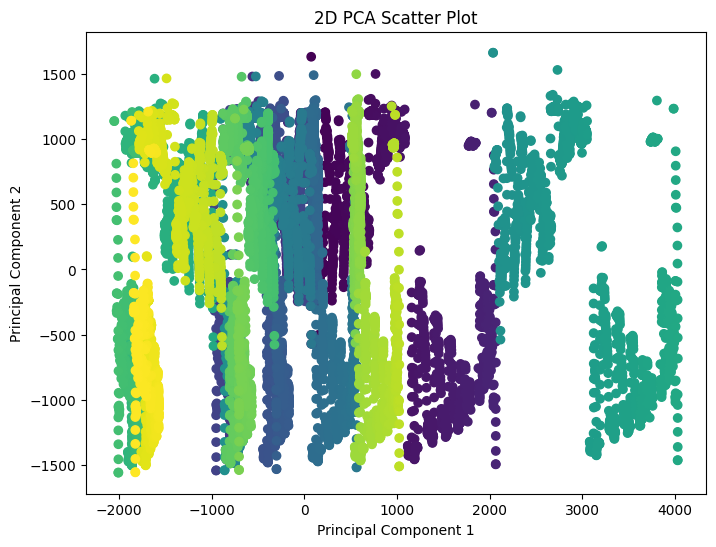

In [60]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=range(len(principal_components)), cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Scatter Plot')
plt.savefig('2D Principal Component Analysis Scatter Plot.png')
plt.show()

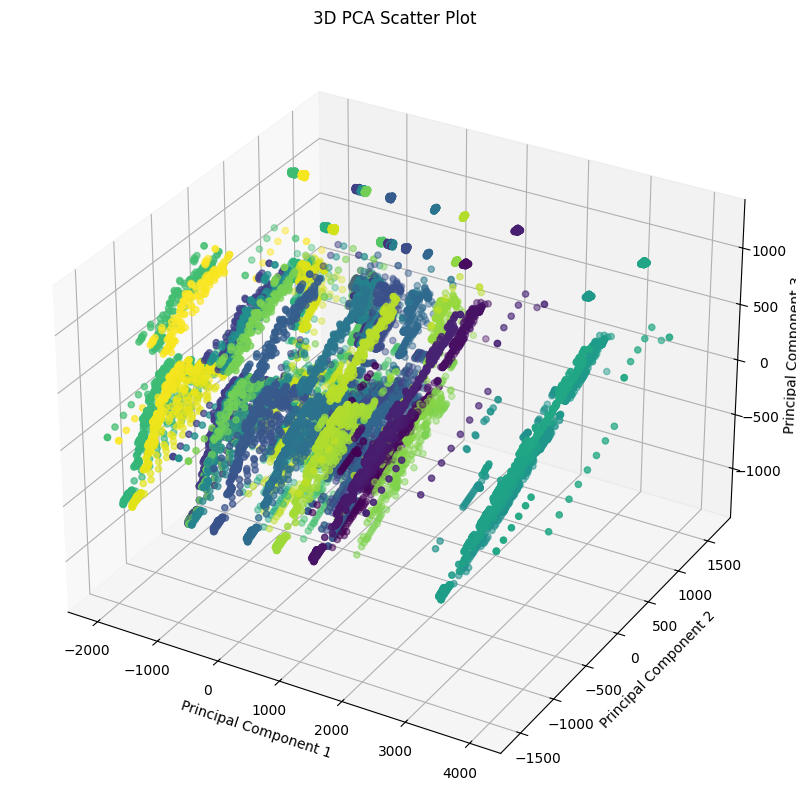

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Option 1: No coloring, just use a single color
# ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], color='b', alpha=0.6)

# Option 2: Color by the index (if you have no specific column)
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=range(len(principal_components)), cmap='viridis')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatter Plot')
plt.savefig('3D Principal Component Analysis Scatter Plot.png')
plt.show()

A <i>biplot</i> combines a scatter plot of the samples and arrows showing the direction and magnitude of the original variables. It’s helpful to understand the contribution of original features to the principal components.

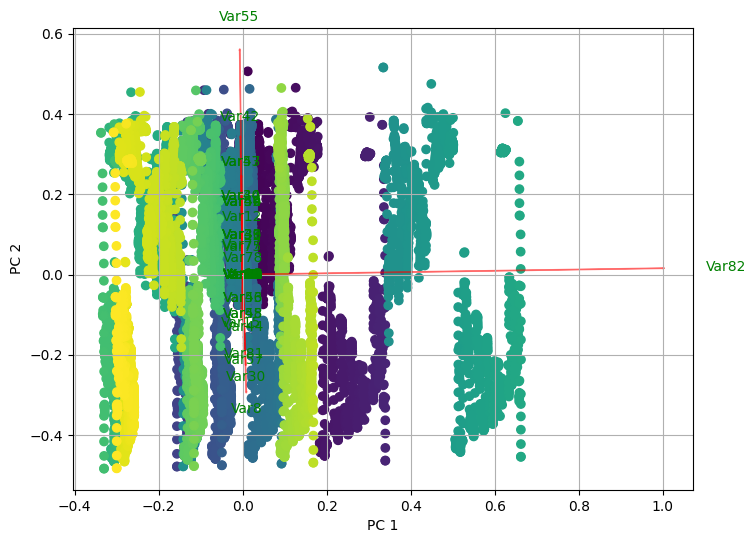

In [62]:
def biplot(principal_components, coeff, labels=None):
    xs = principal_components[:, 0]
    ys = principal_components[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    plt.figure(figsize=(8, 6))
    plt.scatter(xs * scalex, ys * scaley, c=range(len(principal_components)), cmap='viridis')
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, f"Var{i+1}", color='g', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='g', ha='center', va='center')
    
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid()
    plt.savefig('Principal Component Analysis BiPlot.png')
    plt.show()

biplot(principal_components[:, :2], np.transpose(pca.components_))

<i>Cumulative Explained Variance Plot</I> shows the cumulative explained variance as the number of components increases. This helps to determine the optimal number of components.

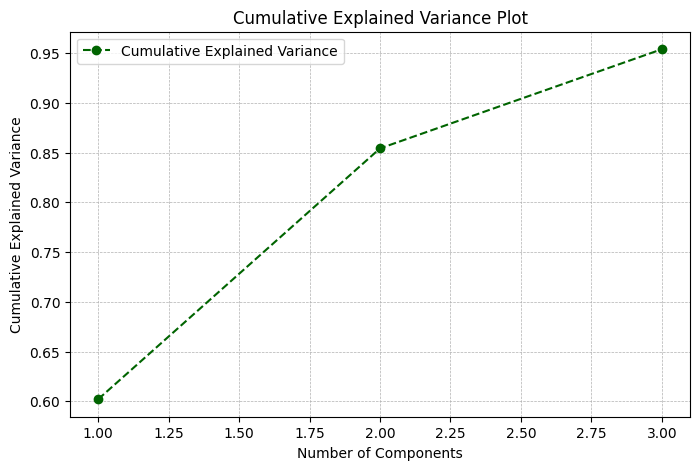

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--', color='darkgreen', label='Cumulative Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.savefig('Cumulative Explained Variance Plot.png')
plt.show()

<i>Heatmap of the Principal Components</I> can be used to show the loading matrix (the weight of each original variable in each principal component).

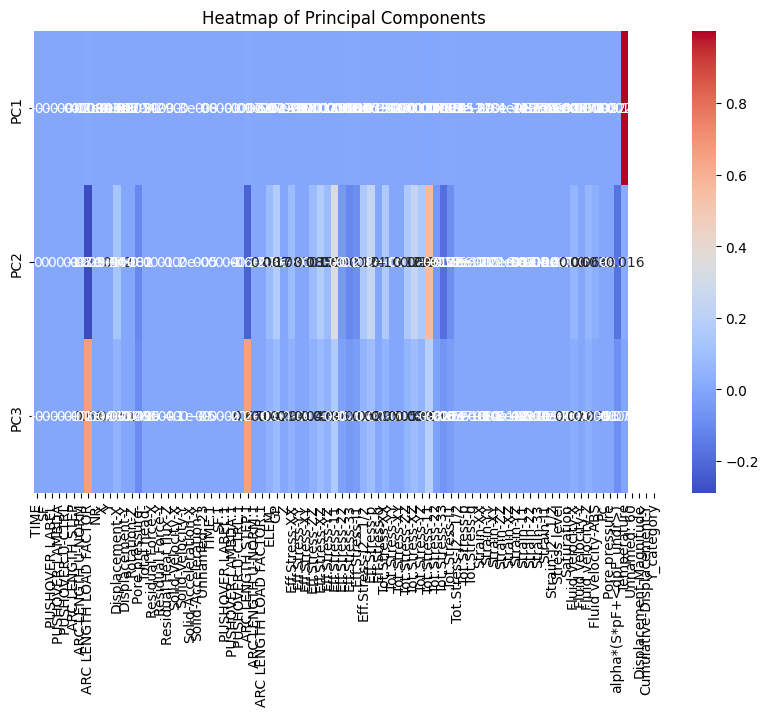

In [65]:
plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True, xticklabels=combined_data.columns, yticklabels=[f'PC{i+1}' for i in range(pca.n_components_)])
plt.title('Heatmap of Principal Components')
plt.savefig('Heatmap of the Principal Components.jpeg')
plt.show()

## Authors:

[Karol Niewitecki](https://www.linkedin.com/in/karol-wilhelm-niewitecki-0385492b7/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkPY0101ENSkillsNetwork19487395-2021-01-01)

Karol Niewitecki is a Master's student in Civil Engineering on Politechnika Krakowska and a Bachelor's student in Electrical Engineering on AGH.